In [12]:
import torch
import torchvision
import shutil 


mean = -0.1
std=1
img_size= 32

batch_size= 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../datasets/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([img_size, img_size]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=batch_size, shuffle=True)

for x,y in train_loader:
    break
    
vmin= x.min().item()
vmax= x.max().item()
print('range : ',vmin, vmax)

range :  0.10000000149011612 1.100000023841858


In [21]:
%load_ext autoreload
%autoreload 2

import torch
import shutil 
import numpy as np
from torch import nn
from modules.kernels import get_gaussian
from modules.models.forward_model import forward_modelA
from modules.models.forward_H import modelH
from modules.custom_activations import inc_m, sigmoid_custom2_with_translation, unit_func
import matplotlib.pyplot as plt
from modules.models.preprocess_H_weights import ifft, fft, fft_2d, ifft_2d, fft_2d_with_fftshift, ifft_2d_with_fftshift
from modules.noise import poisson_noise


device= 'cpu'

sPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)
exPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notes: How to obtain different stages of the forward model

1. Ht= W (When H_weight_preproc, H_activation= unit_func)
2. Ht= Tau (When H_Activation= unit_func)
3. Ht= Ht
4. yt= lambda (When noise= False)
5. yt= yt

In [33]:
from modules.custom_activations import sigmoid_custom
from modules.models.preprocess_H_weights import ifft_2d_with_fftshift_real, identity

T=16
img_size=32
H_weight_preprocess= [identity, ifft_2d_with_fftshift_real][0]
H_complex_init= False
device= 'cpu'
initialization_bias=0
H_activation= [unit_func, sigmoid_custom][0]
H_init= 'fft'

H_generator = modelH(T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, complex_init=H_complex_init, device = device, initialization_bias=initialization_bias, activation = H_activation, init_method= H_init)

Ht=H_generator()

if Ht.dtype == torch.float32: 
    print('not complex : ')
    print(f'range : [{Ht.min()}, {Ht.max()}]')
else:
    print('complex, Real range : ')
    print(f'range : [{Ht.real.min()}, {Ht.real.max()}]')

complex, Real range : 
range : [-88.36544799804688, 84.13050842285156]


In [44]:

def sigmoid_custom2_with_translation(x, m, c=10, p=100, q=6):
    x_dash= p*x+ q
    return 1/(1+torch.exp(-m*x_dash + m*c))

def translation(x, m, p=100, q=6):
    return p*x+q

H_complex_init= True
X= x
initialization_bias= 0
T= 16
m=1

####### change below hyper parameters
H_weight_preprocess= ifft_2d_with_fftshift 
H_activation= unit_func #sigmoid_custom2_with_translation 
noise= True
######

H_generator = modelH(T, img_size, H_weight_preprocess, H_complex_init, device, initialization_bias, activation = H_activation)
Ht= H_generator(m)
yt = forward_modelA(X, Ht, sPSF, exPSF, device, noise, K=1000)

In [45]:
print(Ht.shape)
print(f'range of Ht : [{Ht.min()}, {Ht.max()}]')
print(f'mu, sigma of Ht : [{Ht.mean()}, {Ht.std()}]')

torch.Size([1, 16, 32, 32])
range of Ht : [0.0004083238309249282, 0.10464558005332947]
mu, sigma of Ht : [0.02774956449866295, 0.014504166319966316]


In [43]:
print(Ht.shape)
print(f'range of Ht : [{Ht.min()}, {Ht.max()}]')
print(f'mu, sigma of Ht : [{Ht.mean()}, {Ht.std()}]')

torch.Size([1, 5, 32, 32])
range of Ht : [0.00016941285866778344, 0.08868453651666641]
mu, sigma of Ht : [0.027535330504179, 0.01456360798329115]


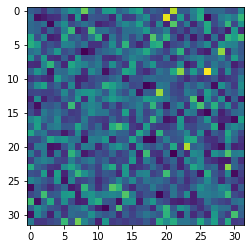

tensor(0.0005, grad_fn=<MinBackward1>) tensor(0.0861, grad_fn=<MaxBackward1>)


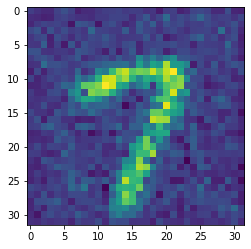

tensor(-0.0025, grad_fn=<MinBackward1>) tensor(0.0244, grad_fn=<MaxBackward1>)


In [9]:
#plt.imshow(x[0,0])
#plt.show()
plt.imshow(Ht[0,0].detach().cpu().numpy())
plt.show()
print(Ht[0,0].min(), Ht[0,0].max())
plt.imshow(yt[0,0].detach().cpu().numpy())
plt.show()
print(yt[0,0].min(), yt[0,0].max())


## Visualization: Poisson Noise vs Normal Approx.

Conclusions:

* Both are in same range when min(K*X)>10

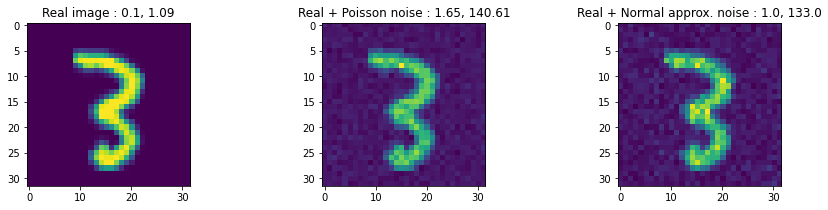

In [123]:
K= 100

z= torch.randn_like(X)  
X_poisson= torch.poisson(X[0,0]*K)
X_normal = K*(X + torch.sqrt(X/K)*z) 


plt.figure(figsize= (15, 3))
plt.subplot(1,3,1)
plt.imshow(X[0,0])
plt.title(f'Real image : {np.round(X[0,0].min().item(), 2)}, {np.round(X[0,0].max().item(), 2)}')
plt.subplot(1,3,2)
plt.imshow(X_normal[0,0])
plt.title(f'Real + Poisson noise : {np.round(X_normal[0,0].min().item(), 2)}, {np.round(X_normal[0,0].max().item(), 2)}')
plt.subplot(1,3,3)
plt.imshow(noisy)
plt.title(f'Real + Normal approx. noise : {np.round(X_poisson.min().item(), 2)}, {np.round(X_poisson.max().item(), 2)}')
plt.show()


## Check forward model with scaling

In [33]:
from modules.models.forward_model import forward_modelA

device = 'cpu'
X= torch.randn((32, 1, 32, 32))
H= torch.randn((1, 5, 32, 32))

sPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)
exPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)


yt = forward_modelA(X, H, sPSF, exPSF, device, noise=True, K=10, scale_factor=1)
print(yt.shape)

downscaled lambda : torch.Size([32, 5, 32, 32])
upscaled yt : torch.Size([32, 5, 32, 32])
torch.Size([32, 5, 32, 32])


## Check new decoder

In [ ]:
from modules.models.decoder import genv1

img_size=32
img_channels=7
T=5
channel_list=[10,3,2,1, 11]
yt= torch.randn((32, T, img_size, img_size))

genv1(T, img_size, img_channels, channel_list)

## Create large images and generate patches

In [48]:
import torch
import torchvision
import shutil 


mean = 0
std=1

img_size=32
torch.manual_seed(10)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../datasets/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([img_size, img_size]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=60000, shuffle=True)

val_test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../datasets/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([img_size, img_size]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=10000, shuffle=True, drop_last= True)

In [51]:
train_data, _ =next(iter(train_loader))
val_test_data, _ =next(iter(val_test_loader))

In [50]:
import numpy as np

save_dir = f"/n/home06/udithhaputhanthri/project_udith/datasets/mnistgrid_imgsize({img_size})"

train_grid = torchvision.utils.make_grid(train_data, padding=0, nrow= 600).permute(1,2,0).cpu().numpy()
val_grid = torchvision.utils.make_grid(val_test_data[:5000], padding=0, nrow= 50).permute(1,2,0).cpu().numpy()
test_grid = torchvision.utils.make_grid(val_test_data[5000:], padding=0, nrow= 50).permute(1,2,0).cpu().numpy()

In [100]:
!rm -rf "/n/home06/udithhaputhanthri/project_udith/datasets/mnistgrid_imgsize(32)"
!mkdir  "/n/home06/udithhaputhanthri/project_udith/datasets/mnistgrid_imgsize(32)"

In [103]:
def save_grids(data, images_per_grid, nrow_per_grid, save_dir, type_):
    try:shutil.rmtree(f"{save_dir}/{type_}")
    except:pass
    os.mkdir(f"{save_dir}/{type_}")
    for i in range(0, len(data), images_per_grid):
        grid = torchvision.utils.make_grid(data[i:i+images_per_grid], padding=0, nrow= nrow_per_grid).permute(1,2,0).cpu().numpy()
        
        
        img_save_dir = f"{save_dir}/{type_}/{i//100+1}.jpg"
        plt.imsave(img_save_dir, grid)
        
        if i%10000==0:print("saving ...  : ", img_save_dir)


In [ ]:
import os
save_dir = f"/n/home06/udithhaputhanthri/project_udith/datasets/mnistgrid_imgsize({img_size})"

save_grids(train_data, 100, 10, save_dir, 'train') # save 600 images
save_grids(val_test_data[:5000], 100, 10, save_dir, 'val') # save 50 images
save_grids(val_test_data[5000:], 100, 10, save_dir, 'test') # save 50 images

## Create a dataloader for load new imagesglob.glob(f"{img_dir}/{type_}/*.jpg")

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image
import glob

class mnistgrid_getdataset(torch.utils.data.Dataset):
    def __init__(self, img_size= 32, type_= 'train', img_dir= "/n/home06/udithhaputhanthri/project_udith/datasets/mnistgrid_imgsize(32)"):
        super(mnistgrid_getdataset, self).__init__()
        self.img_list = glob.glob(f"{img_dir}/{type_}/*.jpg")
        
        self.transform = transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0,), (1,)),
                                torchvision.transforms.RandomCrop((img_size,img_size), padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
                                torchvision.transforms.Grayscale(num_output_channels=1)])
        
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        return self.transform(Image.fromarray(plt.imread(self.img_list[idx])))

In [6]:
img_size= 32
train_loader = torch.utils.data.DataLoader(mnistgrid_getdataset(img_size, 'train'), batch_size=32, shuffle=True, drop_last= True)
val_loader = torch.utils.data.DataLoader(mnistgrid_getdataset(img_size, 'val'), batch_size=32, shuffle=True, drop_last= True)
test_loader = torch.utils.data.DataLoader(mnistgrid_getdataset(img_size, 'test'), batch_size=32, shuffle=True, drop_last= True)


torch.Size([32, 1, 32, 32])
time : 0.3021671772003174 sec


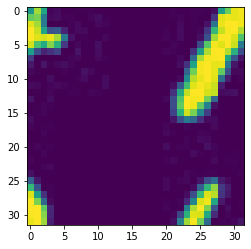

In [7]:
import time

start= time.time()
for x in test_loader:
    print(x.shape)
    plt.imshow(x[0,0])
    
    break
end= time.time()
print(f"time : {end- start} sec")

## Analysing showing functions

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


before normalizaton: show images : X range : [-4.393202781677246, 3.906681776046753] | X_hat range : [-3.7335095405578613, 3.554288625717163]
after normalization: show images : X range : [0.0, 1.0] | X_hat range : [0.0, 1.0]


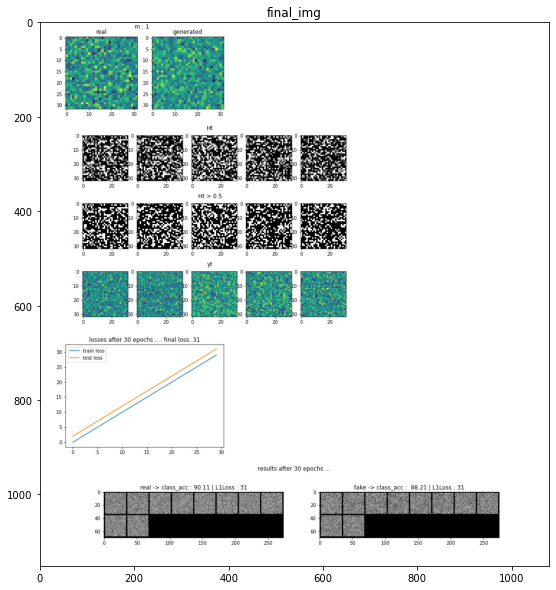

In [28]:
from modules.utils import show_imgs
import torch
import numpy as np

X= torch.randn((10, 1, 32, 32)) 
Ht= torch.randn(1, 5, 32, 32)
X_hat= torch.randn((10, 1, 32, 32)) 
yt= torch.randn((10, 5, 32, 32)) 
losses_train = np.array(range(30))
losses_test = np.array(range(30))+2
T= 5
epoch= 30
class_acc_on_real=90.11
class_acc_on_fake=88.21
!rm -rf $save_dir
save_dir='1'
m=3

show_imgs(X, Ht, X_hat, yt, losses_train, losses_test,T, epoch, class_acc_on_real, class_acc_on_fake, save_dir, m=1)

## Eval metrics

In [90]:
import torch
from torch.nn import functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from ignite.metrics import SSIM as SSIM_IGNITE



def mse_distance(X_hat, X):
    return F.mse_loss(X_hat, X).item()

In [111]:

def ssim_custom_lib(X_hat, X, data_range):
    data_range= 1.0
    return ssim(X, X_hat, data_range=data_range, size_average=False).mean().item()
    
def ssim_ignite(X_hat, X, data_range):
    data_range= 1.0
    metric = SSIM_IGNITE(data_range)
    metric.update((X_hat, X))
    return metric.compute().item()
    

In [ ]:
X= torch.randint(0, 255, (32, 1, 32, 32))/255.0
X_hat= torch.randint(0, 255, (32, 1, 32, 32))/255.0

ssim_custom_lib(X_hat, X, data_range), ssim_ignite(X_hat, X, data_range), mse_distance(X_hat, X)

In [116]:
from modules.eval_metrics import ssim_ignite, mse_distance
ssim_ignite(X_hat, X, data_range), mse_distance(X_hat, X)

(0.005476000275276227, 0.1665312945842743)

## Check model sizes

In [129]:
from modules.models.decoder import genv1
from modules.models.forward_H import modelH_class
from modules.models.preprocess_H_weights import ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom


T= 32
img_size= 128
img_channels=1
channel_list= [24, 12, 8, 4, 2]
last_activation='sigmoid'

decoder = genv1(T, img_size, img_channels, channel_list, last_activation)
modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= ifft_2d_with_fftshift_real, complex_init=False, device = 'cpu', initialization_bias=0, activation = sigmoid_custom, init_method= 'fft', enable_train=True)


In [134]:
epoch = 10
losses_train=[1.0]*200
losses_test=[1.0]*200
m= 10

torch.save({
            'epoch':epoch, 
            'loss_train':losses_train, 
            'loss_val':losses_test,
            'm_in_custom_sigmoid':m,
            'decoder_state_dict': model.state_dict(),
            'modelH_weights': modelH.weights,
            }, './test.pth')

In [135]:
!du -sh test.pth

4.9M	test.pth


In [123]:
!rm test.pth

## SSIM experiments: with kernel size

In [74]:
import glob

data_dir = 'figs/mnistv7'
without_learning_img_dirs = sorted(glob.glob(f'{data_dir}/*lr_H(0.0)*/save_special/150*'))
with_learning_img_dirs = sorted(glob.glob(f'{data_dir}/*lr_H(10.0)*/save_special/145*'))

import numpy as np
import matplotlib.pyplot as plt

#np_img_dirs= without_learning_img_dirs
#train='False'

np_img_dirs= with_learning_img_dirs
train='True'

ht = np.load(np_img_dirs[0])
x_pred = np.load(np_img_dirs[1])
x = np.load(np_img_dirs[2])
yt = np.load(np_img_dirs[3])

x_pred =  (x_pred - x_pred.min())/(x_pred.max()- x_pred.min())
x =  (x - x.min())/(x.max()- x.min())

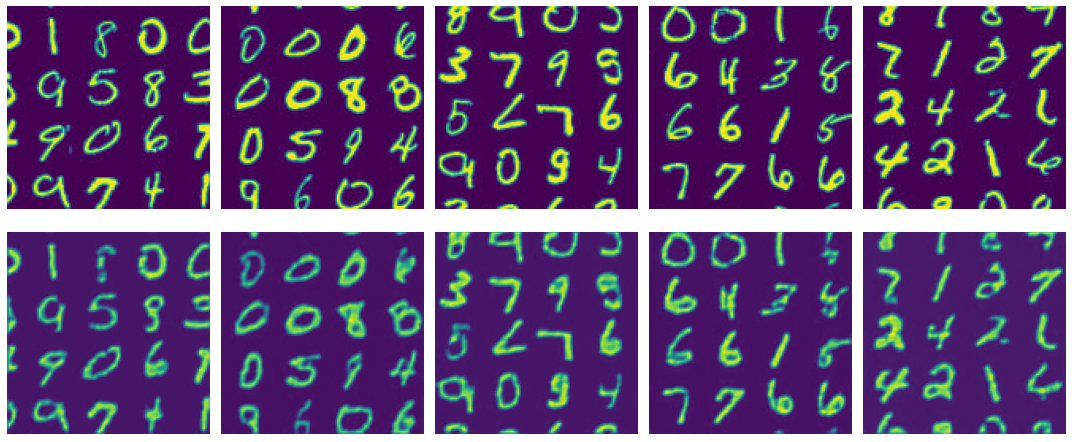

In [75]:
plt.figure(figsize= (15,3.2*3))

ticks = list(map(int,np.linspace(0, 128, 5)))
tick_fontsize= 13
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(x[i, 0])
    plt.axis('off')
    plt.yticks(ticks, ticks, rotation=0, fontsize=tick_fontsize)
    plt.xticks(ticks, ticks, rotation=0, fontsize=tick_fontsize)
    
    plt.subplot(3,5,5+i+1)
    plt.imshow(x_pred[i, 0])
    plt.axis('off')
    plt.yticks(ticks, ticks, rotation=0, fontsize=tick_fontsize)
    plt.xticks(ticks, ticks, rotation=0, fontsize=tick_fontsize)
    
    
plt.tight_layout()
plt.show()

In [96]:
import torch
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from ignite.metrics import SSIM as SSIM_IGNITE

def mse_distance(X_hat, X):
    return F.mse_loss(X_hat, X).item()

def compare_ssim(x, x_pred, exp_name='test'): #x, x_pred -> are single numpy images (with shape: (c, n, n)) with range of [0,1]
    x = np.expand_dims(x, 0)
    x_pred = np.expand_dims(x_pred, 0)
    
    plt.figure(figsize= (6,3))
    plt.subplot(1,2,1)
    plt.imshow(x[0, 0], vmin=0, vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(x_pred[0, 0], vmin=0, vmax=1)
    plt.suptitle(exp_name)
    plt.tight_layout()
    plt.show()
    
    X= torch.as_tensor(x)
    X_hat= torch.as_tensor(x_pred)
    print(f'X range : [{X.min()}, {X.max()}] || X_hat range : [{X_hat.min()}, {X_hat.max()}]')

    for k in [3, 11, 31]:
        custom_ssim = ssim(X, X_hat, data_range= 1.0, size_average=False, win_size=k).mean().item()
        metric = SSIM_IGNITE(data_range = 1.0, kernel_size= (k,k))
        metric.update((X_hat, X))
        ignite_ssim = metric.compute().item()

        #print(f'kernel_size : {k} ::: custom ssim : {custom_ssim} || ignite_ssim : {ignite_ssim}')
        print(f'kernel_size : {k} ::: ignite_ssim : {ignite_ssim}')

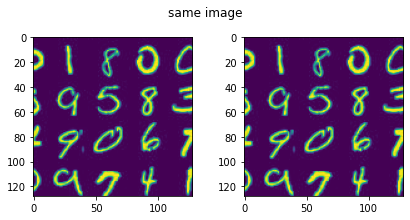

X range : [0.0, 1.0] || X_hat range : [0.0, 1.0]
kernel_size : 3 ::: ignite_ssim : 1.0
kernel_size : 11 ::: ignite_ssim : 1.0
kernel_size : 31 ::: ignite_ssim : 1.0


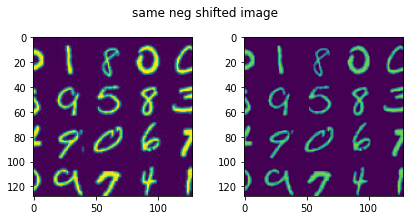

X range : [0.0, 1.0] || X_hat range : [-0.20000000298023224, 0.800000011920929]
kernel_size : 3 ::: ignite_ssim : 0.08359391795402837
kernel_size : 11 ::: ignite_ssim : 0.05272804258548916
kernel_size : 31 ::: ignite_ssim : 0.05249611198910187


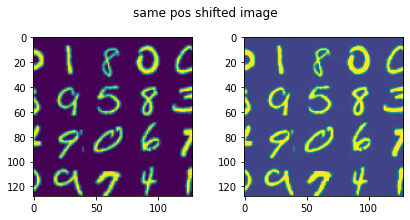

X range : [0.0, 1.0] || X_hat range : [0.20000000298023224, 1.2000000476837158]
kernel_size : 3 ::: ignite_ssim : 0.2869123163943641
kernel_size : 11 ::: ignite_ssim : 0.35376457254145066
kernel_size : 31 ::: ignite_ssim : 0.3539317567252027


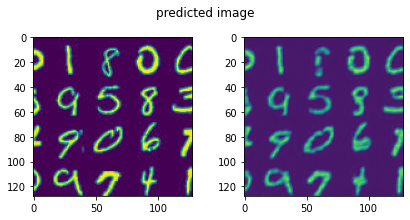

X range : [0.0, 1.0] || X_hat range : [0.01811300590634346, 0.8865036368370056]
kernel_size : 3 ::: ignite_ssim : 0.284457980044307
kernel_size : 11 ::: ignite_ssim : 0.390728677982322
kernel_size : 31 ::: ignite_ssim : 0.39114684203554617


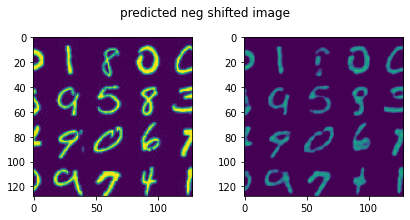

X range : [0.0, 1.0] || X_hat range : [-0.18188700079917908, 0.6865036487579346]
kernel_size : 3 ::: ignite_ssim : 0.03728171927422282
kernel_size : 11 ::: ignite_ssim : 0.0048255650285768115
kernel_size : 31 ::: ignite_ssim : 0.004544805629947277


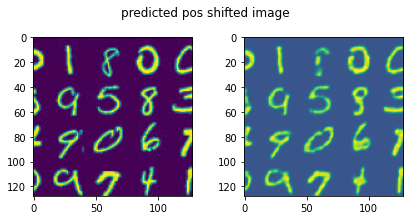

X range : [0.0, 1.0] || X_hat range : [0.2181130051612854, 1.0865036249160767]
kernel_size : 3 ::: ignite_ssim : 0.19981413576617535
kernel_size : 11 ::: ignite_ssim : 0.2741340137164876
kernel_size : 31 ::: ignite_ssim : 0.274294197668457


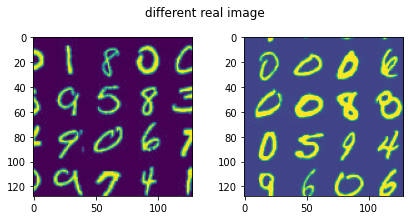

X range : [0.0, 1.0] || X_hat range : [0.20000000298023224, 1.2000000476837158]
kernel_size : 3 ::: ignite_ssim : 0.018446996166761504
kernel_size : 11 ::: ignite_ssim : 0.0067835109928079795
kernel_size : 31 ::: ignite_ssim : 0.006721801988803079


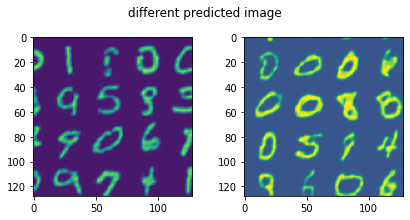

X range : [0.01811300590634346, 0.8865036368370056] || X_hat range : [0.2260485589504242, 1.1447914838790894]
kernel_size : 3 ::: ignite_ssim : 0.22347114100522414
kernel_size : 11 ::: ignite_ssim : 0.12186589776917103
kernel_size : 31 ::: ignite_ssim : 0.1208452396198837


In [97]:
compare_ssim(x[0], x[0], 'same image')
compare_ssim(x[0], x[0]-0.2, 'same neg  shifted image')
compare_ssim(x[0], x[0]+0.2, 'same pos  shifted image')

compare_ssim(x[0], x_pred[0], 'predicted image')
compare_ssim(x[0], x_pred[0]-0.2, 'predicted neg  shifted image')
compare_ssim(x[0], x_pred[0]+0.2, 'predicted pos  shifted image')

compare_ssim(x[0], x[1]+0.2, 'different real image')
compare_ssim(x_pred[0], x_pred[1]+0.2, 'different predicted image')



## Impulse response as sPSF, exPSF

In [1]:
from modules.kernels import get_gaussian

In [4]:
get_gaussian(side_len=5, s=1)

array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

In [9]:
import numpy as np
def impulse(side_len=5):
    mid = side_len//2
    kernel = np.zeros((side_len,side_len), dtype= 'float')
    kernel[mid, mid] = 1.0
    return kernel